# Обучение с учителем для контроля окна перегрузки

### Основная идея

Мы использовуем обучение с подкреплением для обучения функции, которая дает инцормацию о состоянии и возвращает действие, которое отправитель TCP должен принять:

* Увеличить значение окна перегрузки
* Уменьшить значение окна перегрузки
* Удерживать значение окна перегрузки

### Q обучение

Q обучение - это итеративный процесс для определения того, какой должна быть эта функция.

Процесс определения:
1. Случайно выбираем начальное действие
2. После выполнения действия оцениваем вознаграждение (reward)
3. Используем полученные значения для обновления таблицы Q, которая представляет собой таблицу, в которой для всех состояний и пар действий определяется наибольшая ожидаемая награда.

В нашем случае наше состояние (state) представляет собой последовательность исторически видимых задержек RTT, и каждое из действий соответствует описанному выше.

### Но у нас много состояний

Поскольку наши последовательности времени прохождения туда-обратно бесконечны, мы не можем использовать простую таблицу состояний. Вместо этого мы приближаем эту таблицу с нейронной сетью, в частности, с таблицей, предназначенной для хранения последовательностей, называемой LSTM (долгосрочной кратковременной памятью).

### LSTM - долгосрочная кратковременная память

LSTM разработаны специально, чтобы избежать проблемы долговременной зависимости. Запоминание информации на долгие периоды времени – это их обычное поведение, а не что-то, чему они с трудом пытаются обучиться.

Любая рекуррентная нейронная сеть имеет форму цепочки повторяющихся модулей нейронной сети. В обычной RNN структура одного такого модуля очень проста, например, он может представлять собой один слой с функцией активации tanh (гиперболический тангенс):
![LSTM](LSTM.png)

На схеме выше каждая линия переносит целый вектор от выхода одного узла ко входу другого. Розовыми кружочками обозначены поточечные операции, такие, как сложение векторов, а желтые прямоугольники – это обученные слои нейронной сети. Сливающиеся линии означают объединение, а разветвляющиеся стрелки говорят о том, что данные копируются и копии уходят в разные компоненты сети.

Ключевой компонент LSTM – это состояние ячейки (cell state) – горизонтальная линия, проходящая по верхней части схемы.
Состояние ячейки напоминает конвейерную ленту. Она проходит напрямую через всю цепочку, участвуя лишь в нескольких линейных преобразованиях. Информация может легко течь по ней, не подвергаясь изменениям.

Тем не менее, LSTM может удалять информацию из состояния ячейки; этот процесс регулируется структурами, называемыми фильтрами (gates).
Фильтры позволяют пропускать информацию на основании некоторых условий. Они состоят из слоя сигмоидальной нейронной сети и операции поточечного умножения.

Сигмоидальный слой возвращает числа от нуля до единицы, которые обозначают, какую долю каждого блока информации следует пропустить дальше по сети. Ноль в данном случае означает “не пропускать ничего”, единица – “пропустить все”.
В LSTM три таких фильтра, позволяющих защищать и контролировать состояние ячейки.


### Обучение сети:
Выполняем запуск необходимых библиотек.

In [1]:
# импортируем все необходимые библиотеки
import socket
import select
import json
import time
import matplotlib.pyplot as plt
import argparse
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.transforms as T
import math
import random
import numpy as np

from os import mkdir
from os.path import join, exists
from typing import List, Dict, Tuple, Optional
from collections import namedtuple
from itertools import count
from src.plot_print_TCP_ML import run_mah_settings, open_tcp_port, print_performance_ML, run_mah_settings_ML
from src.senders import Sender
from src.machine_learning_TCP import ReinforcementAlgorithm
from src.pytorch_TCP_MachineLearning import LSTM_DQN

# список временных меток по которым отправитель может отправлять 1500-байтовый пакет
TRACE_FILES = {
    '0.57MBPS': '0.57mbps.trace',
    '2.64MBPS': '2.64mbps.trace',
    '3.04MBPS': '3.04mbps.trace',
    '5.65MBPS': '5.65mbps.trace',
    '100.42MBPS': '100.42mbps.trace',
    '114.68MBPS': '114.68mbps.trace'
}

In [2]:
mah_settings = {
    'delay': 88,
    'trace_file': '2.64mbps.trace',
    'queue_type': 'droptail',
    'downlink_queue_options': {
        'bytes': 30000
    }
}

***Episode # 0***
[Отправитель] Подключен к получателю: 100.64.0.2:46709



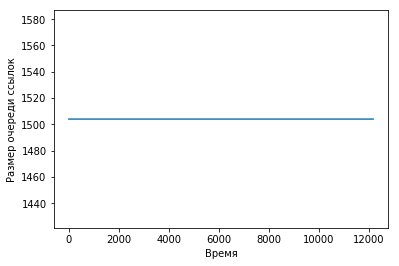

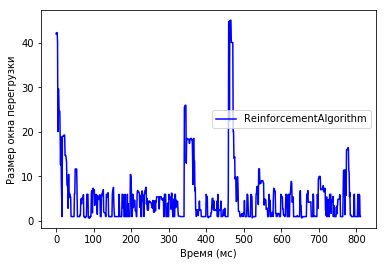

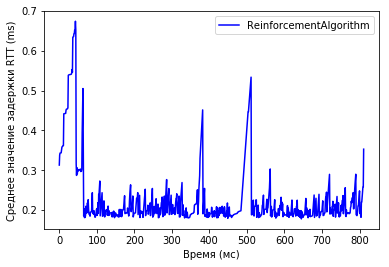

***Episode # 1***
[Отправитель] Подключен к получателю: 100.64.0.2:36712



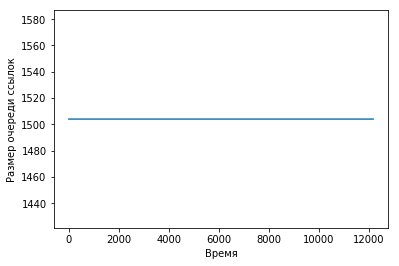

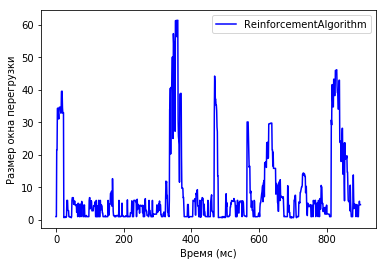

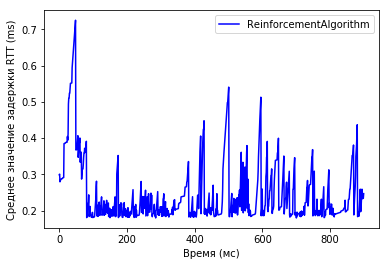

***Episode # 2***
[Отправитель] Подключен к получателю: 100.64.0.2:46301



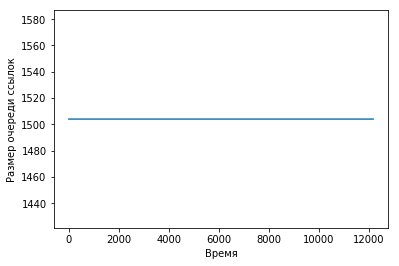

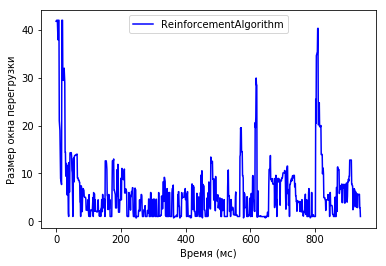

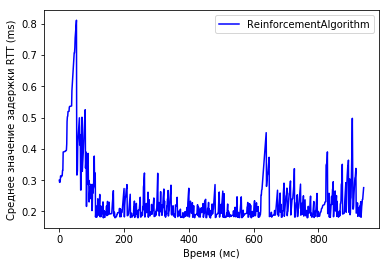

***Episode # 3***
[Отправитель] Подключен к получателю: 100.64.0.2:43139



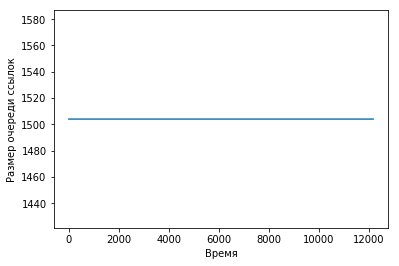

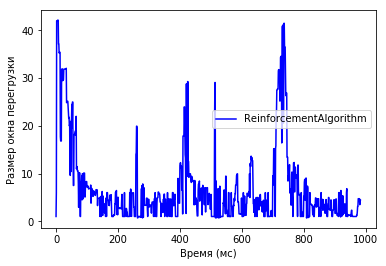

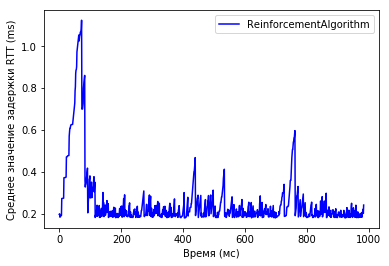

***Episode # 4***
[Отправитель] Подключен к получателю: 100.64.0.2:35575



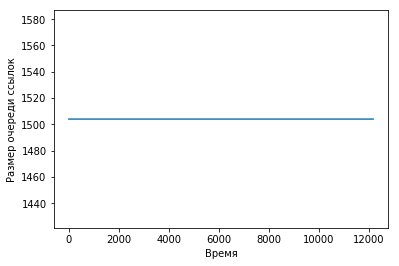

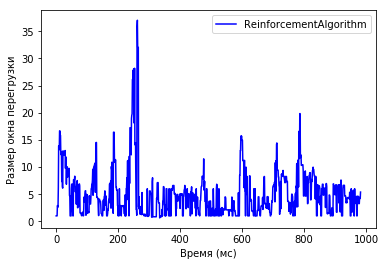

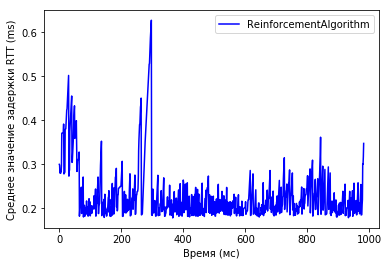

***Episode # 5***
[Отправитель] Подключен к получателю: 100.64.0.2:49897



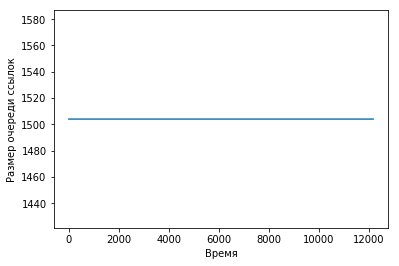

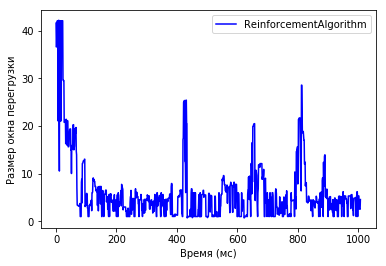

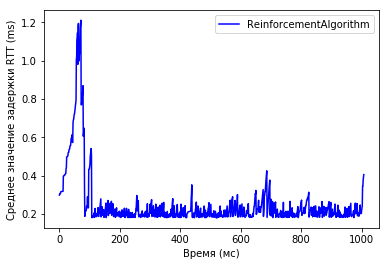

***Episode # 6***
[Отправитель] Подключен к получателю: 100.64.0.2:41792



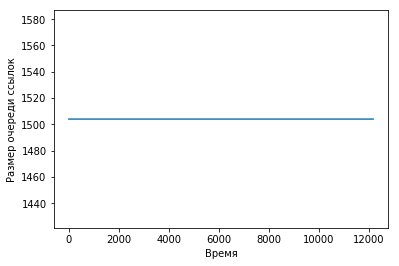

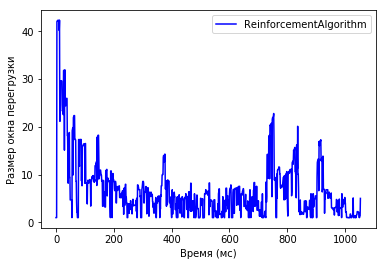

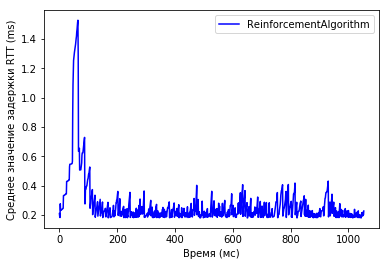

***Episode # 7***
[Отправитель] Подключен к получателю: 100.64.0.2:35600



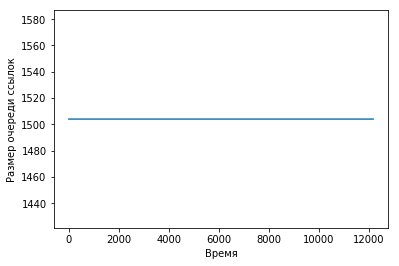

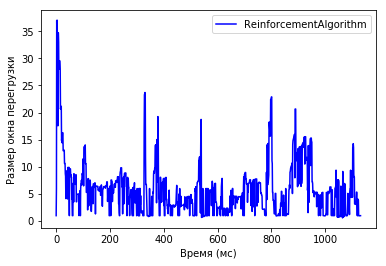

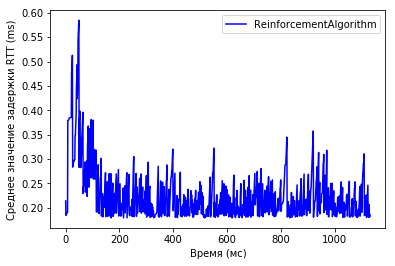

***Episode # 8***
[Отправитель] Подключен к получателю: 100.64.0.2:58955



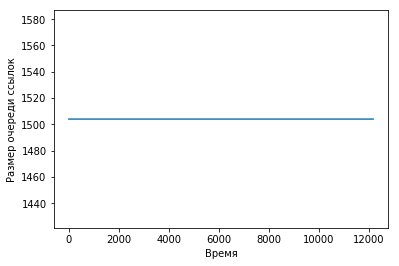

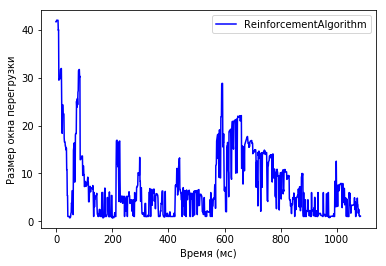

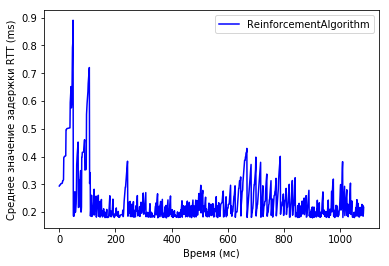

***Episode # 9***
[Отправитель] Подключен к получателю: 100.64.0.2:53499



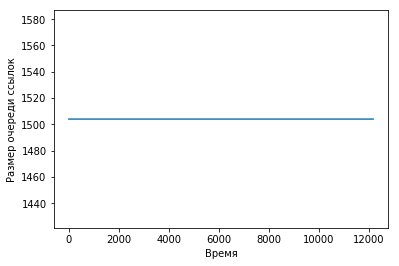

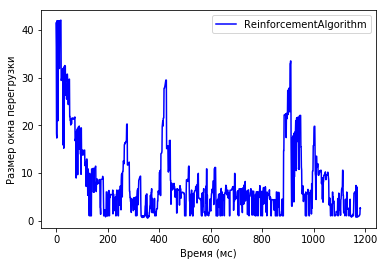

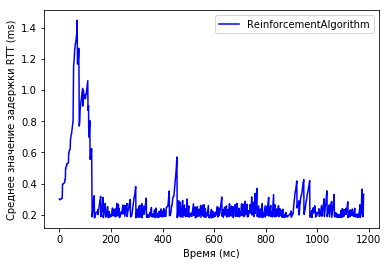

***Episode # 10***
[Отправитель] Подключен к получателю: 100.64.0.2:35252



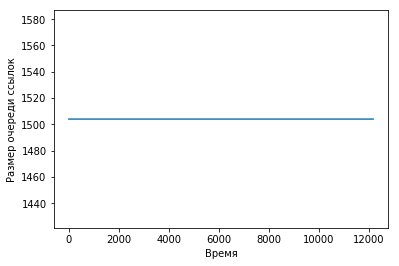

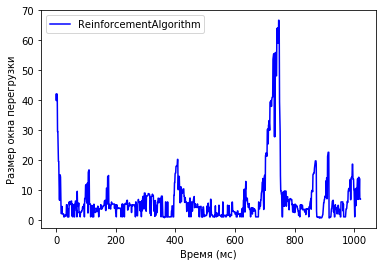

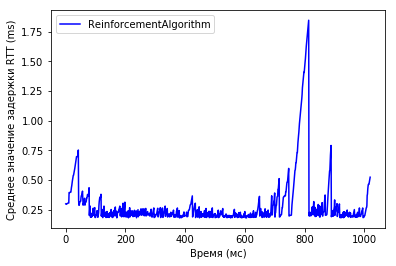

***Episode # 11***
[Отправитель] Подключен к получателю: 100.64.0.2:39776



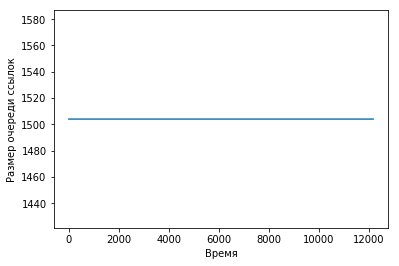

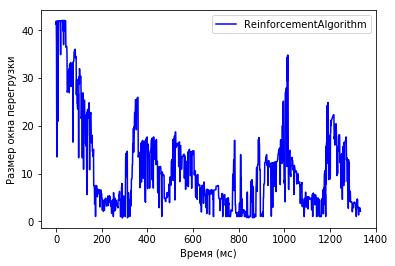

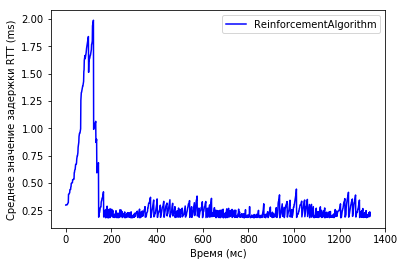

***Episode # 12***
[Отправитель] Подключен к получателю: 100.64.0.2:51333



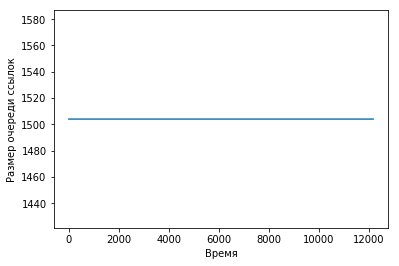

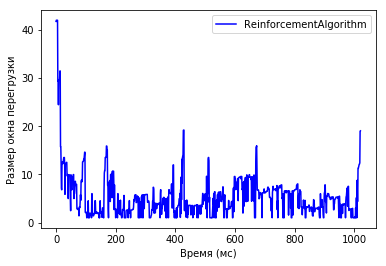

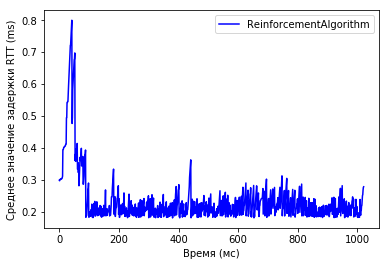

***Episode # 13***
[Отправитель] Подключен к получателю: 100.64.0.2:44112



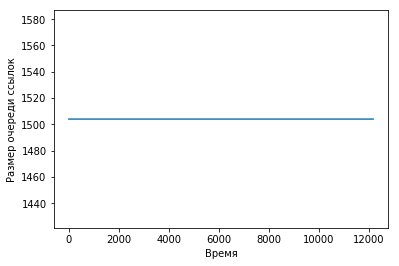

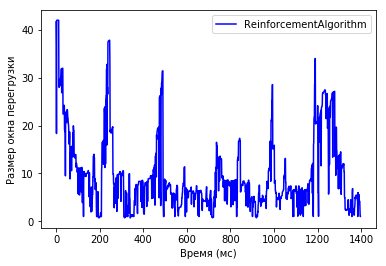

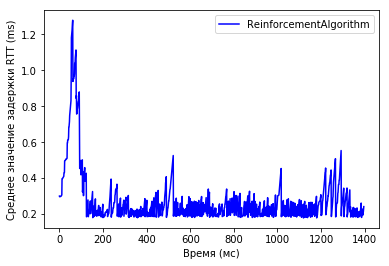

***Episode # 14***
[Отправитель] Подключен к получателю: 100.64.0.2:48110



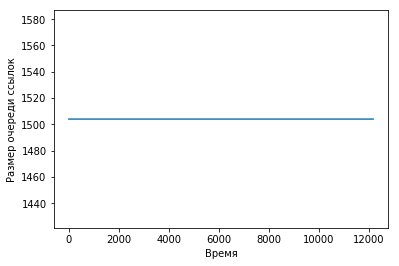

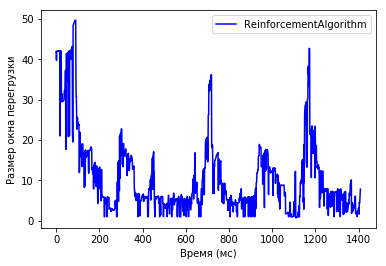

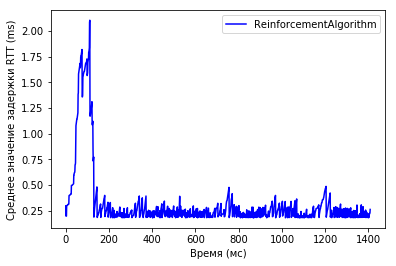

***Episode # 15***
[Отправитель] Подключен к получателю: 100.64.0.2:46138



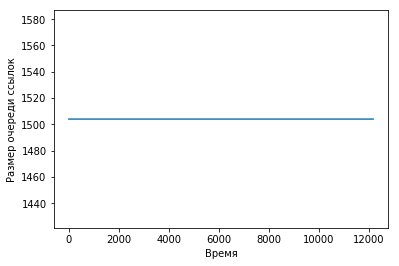

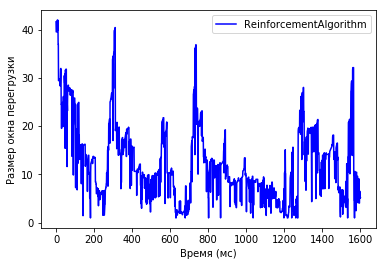

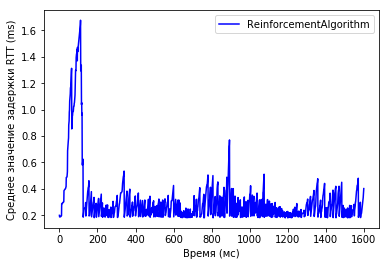

***Episode # 16***
[Отправитель] Подключен к получателю: 100.64.0.2:50551



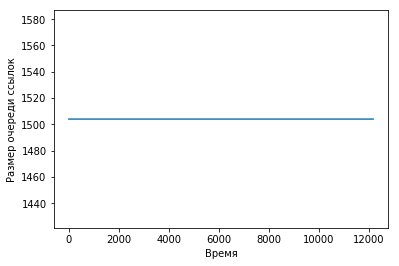

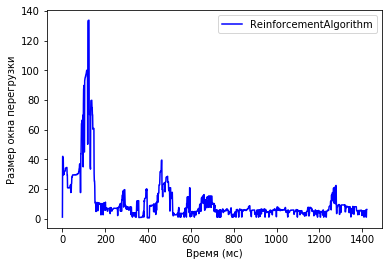

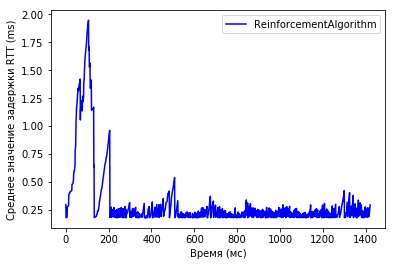

***Episode # 17***
[Отправитель] Подключен к получателю: 100.64.0.2:53099



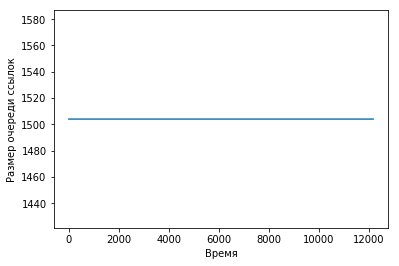

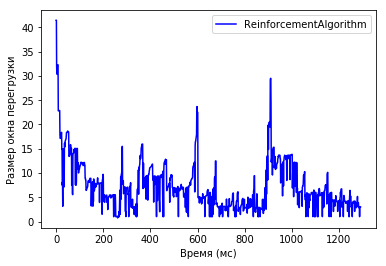

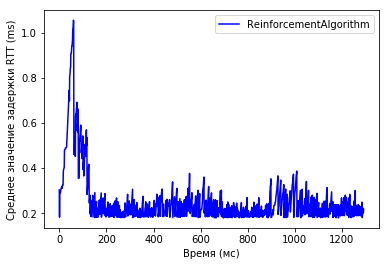

***Episode # 18***
[Отправитель] Подключен к получателю: 100.64.0.2:52132



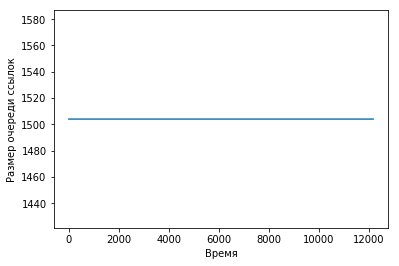

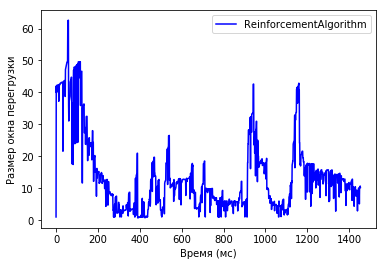

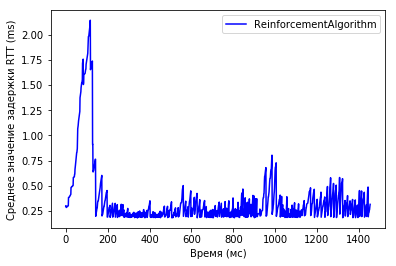

***Episode # 19***
[Отправитель] Подключен к получателю: 100.64.0.2:46273



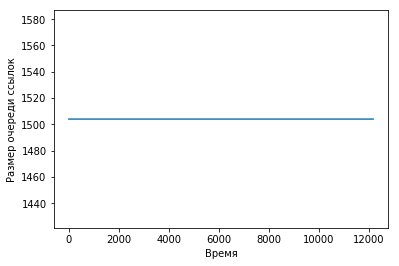

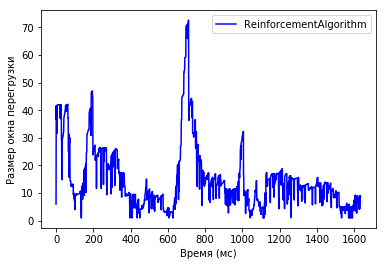

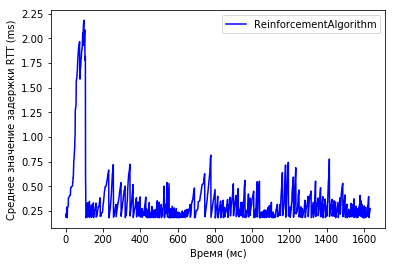

***Episode # 20***
[Отправитель] Подключен к получателю: 100.64.0.2:36571



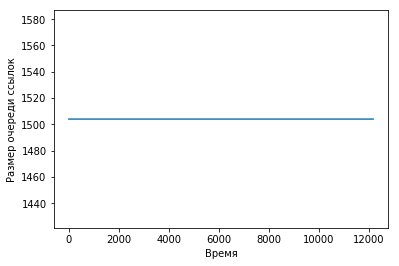

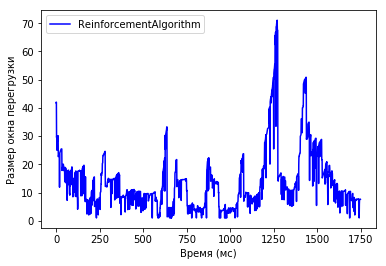

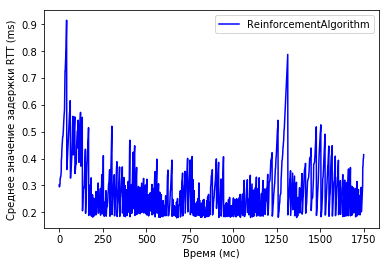

***Episode # 21***
[Отправитель] Подключен к получателю: 100.64.0.2:46641



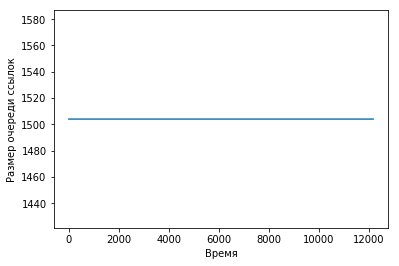

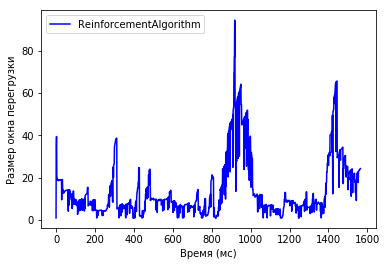

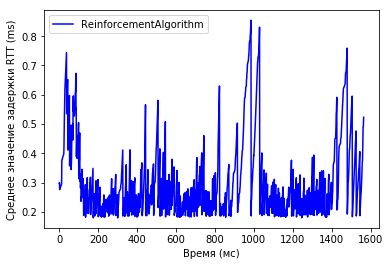

***Episode # 22***
[Отправитель] Подключен к получателю: 100.64.0.2:42599



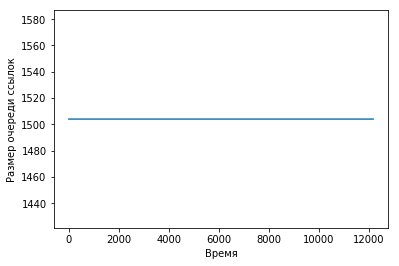

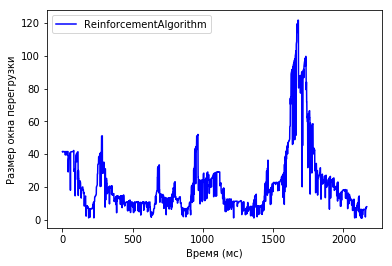

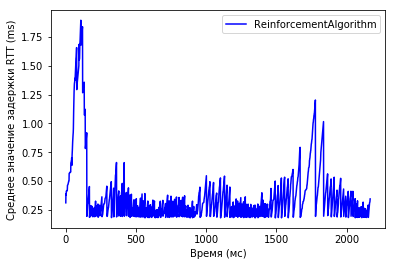

***Episode # 23***
[Отправитель] Подключен к получателю: 100.64.0.2:51383



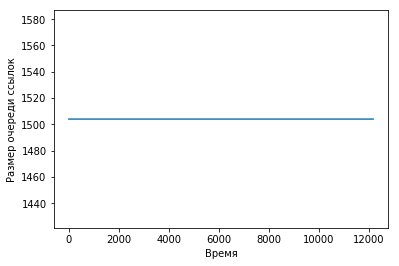

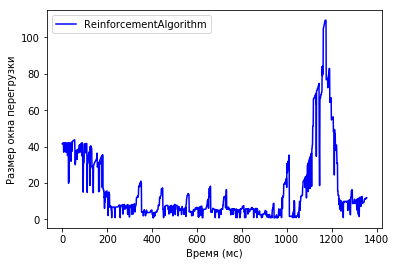

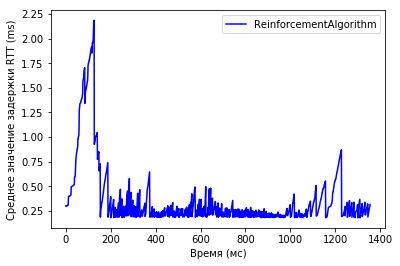

***Episode # 24***
[Отправитель] Подключен к получателю: 100.64.0.2:39153



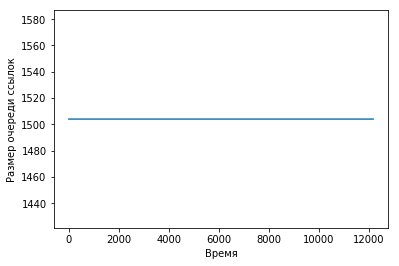

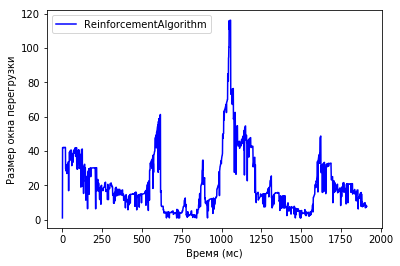

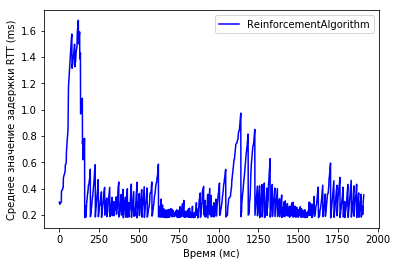

***Episode # 25***


In [ ]:
OUT_DIRECTORY = "experiments"
EXP_PREFIX = "experiment_"
HYPERPARAMS_FILENAME = "hyperparameters.txt"

def run_tcp_ml(hyperparameters_file_name):
    """Запуск процесса парсинга файлов и модели ML."""
    # записываем результаты
    experiment_dir = join(OUT_DIRECTORY, EXP_PREFIX)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if not exists(OUT_DIRECTORY):
        mkdir(OUT_DIRECTORY)

    if not exists(experiment_dir):
        mkdir(experiment_dir)

    hyperparameters = None
    with open(hyperparameters_file_name) as hyperparams_file:
        hyperparameters = json.loads(hyperparams_file.read())

    NUM_EPISODES = hyperparameters['HYPERPARAMETERS']['NUM_EPISODES'] # количество эпох
    TARGET_UPDATE = hyperparameters['HYPERPARAMETERS']['TARGET_UPDATE'] # обновление значений

    policy_net = LSTM_DQN(hyperparameters['lstm_config'], device).to(device=device)
    target_net = LSTM_DQN(hyperparameters['lstm_config'], device).to(device=device)

    target_net.load_state_dict(policy_net.state_dict())
    optimizer = optim.RMSprop(policy_net.parameters())
    transitions = []
    total_losses = []
    for i in range(NUM_EPISODES):
        port = open_tcp_port()
        algorithm = ReinforcementAlgorithm(policy_net = policy_net, target_net = target_net, device = device, optimizer = optimizer, hyperparameters = hyperparameters['HYPERPARAMETERS'], episode_num = i, transitions = transitions)
        print("***Эпоха # %d***" % i)
        run_mah_settings(mah_settings, 60, [Sender(port, algorithm)], True, i%20, write_to_disk = True, output_dir= OUT_DIRECTORY, experiment_dir=experiment_dir)
        # производим запоминание rtt, cwnd, stats и очереди
        total_losses.append(algorithm.losses)
        if i % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())
            # модель
            policy_net_filename = join( experiment_dir, "policy-net_episode-" + str(i) + ".model" )
            torch.save(policy_net.state_dict(), policy_net_filename)

    # рассчитаем потери
    colors = ["red", "blue", "green", "yellow", "magenta"]
    start = 0
    for i,loss_array in enumerate(total_losses):
        x = list(range(start, start + len(loss_array)))
        plt.plot(x, loss_array, c=colors[i % 5])
        start += len(loss_array)
    plt.show()


run_tcp_ml(hyperparameters_file_name = 'hyperparameters_1.json')

***Эпоха # 0***
[Отправитель] Подключен к получателю: 100.64.0.2:60950

Результаты для отправителя 39936, с алгоритмом: ReinforcementAlgorithm
Пропускная способность (бит/с): 954.666667
Среднее значение задержки RTT (мс): 205.865062



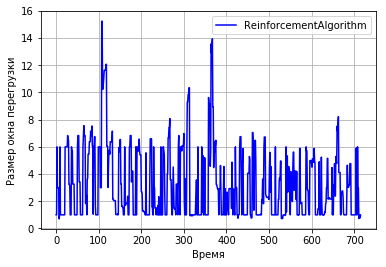

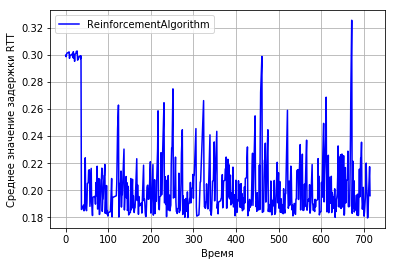

***Эпоха # 1***
[Отправитель] Подключен к получателю: 100.64.0.4:44524

***Эпоха # 2***
[Отправитель] Подключен к получателю: 100.64.0.2:35629

***Эпоха # 3***
[Отправитель] Подключен к получателю: 100.64.0.4:54320

***Эпоха # 4***
[Отправитель] Подключен к получателю: 100.64.0.2:53643

***Эпоха # 5***
[Отправитель] Подключен к получателю: 100.64.0.4:60518

***Эпоха # 6***
[Отправитель] Подключен к получателю: 100.64.0.2:48312

***Эпоха # 7***
[Отправитель] Подключен к получателю: 100.64.0.4:53238

***Эпоха # 8***
[Отправитель] Подключен к получателю: 100.64.0.2:33914

***Эпоха # 9***
[Отправитель] Подключен к получателю: 100.64.0.4:42705

***Эпоха # 10***
[Отправитель] Подключен к получателю: 100.64.0.2:46275

***Эпоха # 11***
[Отправитель] Подключен к получателю: 100.64.0.4:45149

***Эпоха # 12***
[Отправитель] Подключен к получателю: 100.64.0.2:42304

***Эпоха # 13***
[Отправитель] Подключен к получателю: 100.64.0.4:40696

***Эпоха # 14***
[Отправитель] Подключен к получателю: 100.6

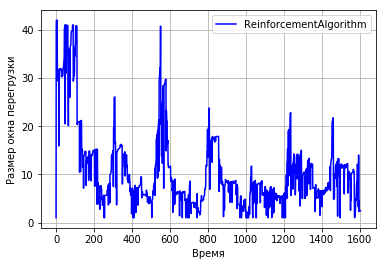

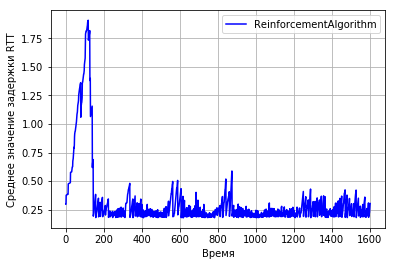

***Эпоха # 21***
[Отправитель] Подключен к получателю: 100.64.0.4:37273

***Эпоха # 22***
[Отправитель] Подключен к получателю: 100.64.0.2:50272

***Эпоха # 23***
[Отправитель] Подключен к получателю: 100.64.0.4:55537

***Эпоха # 24***
[Отправитель] Подключен к получателю: 100.64.0.2:47575

***Эпоха # 25***
[Отправитель] Подключен к получателю: 100.64.0.4:60268

***Эпоха # 26***
[Отправитель] Подключен к получателю: 100.64.0.2:40922

***Эпоха # 27***
[Отправитель] Подключен к получателю: 100.64.0.4:49247

***Эпоха # 28***
[Отправитель] Подключен к получателю: 100.64.0.2:47748

***Эпоха # 29***
[Отправитель] Подключен к получателю: 100.64.0.4:51572

***Эпоха # 30***
[Отправитель] Подключен к получателю: 100.64.0.2:45462

***Эпоха # 31***
[Отправитель] Подключен к получателю: 100.64.0.4:46794

***Эпоха # 32***
[Отправитель] Подключен к получателю: 100.64.0.2:44110

***Эпоха # 33***
[Отправитель] Подключен к получателю: 100.64.0.4:58493

***Эпоха # 34***
[Отправитель] Подключен к получате

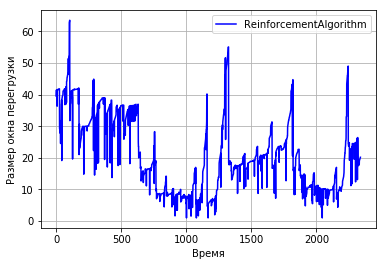

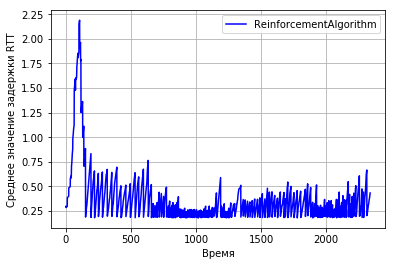

***Эпоха # 41***
[Отправитель] Подключен к получателю: 100.64.0.4:39914

***Эпоха # 42***
[Отправитель] Подключен к получателю: 100.64.0.2:53538

***Эпоха # 43***
[Отправитель] Подключен к получателю: 100.64.0.4:34639

***Эпоха # 44***
[Отправитель] Подключен к получателю: 100.64.0.2:51261

***Эпоха # 45***
[Отправитель] Подключен к получателю: 100.64.0.4:46911

***Эпоха # 46***
[Отправитель] Подключен к получателю: 100.64.0.2:34265

***Эпоха # 47***
[Отправитель] Подключен к получателю: 100.64.0.4:35732

***Эпоха # 48***
[Отправитель] Подключен к получателю: 100.64.0.2:54683

***Эпоха # 49***
[Отправитель] Подключен к получателю: 100.64.0.4:36629

***Эпоха # 50***
[Отправитель] Подключен к получателю: 100.64.0.2:44383

***Эпоха # 51***
[Отправитель] Подключен к получателю: 100.64.0.4:33408

***Эпоха # 52***
[Отправитель] Подключен к получателю: 100.64.0.2:34848

***Эпоха # 53***
[Отправитель] Подключен к получателю: 100.64.0.4:50977

***Эпоха # 54***
[Отправитель] Подключен к получате

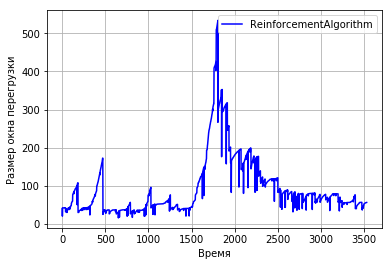

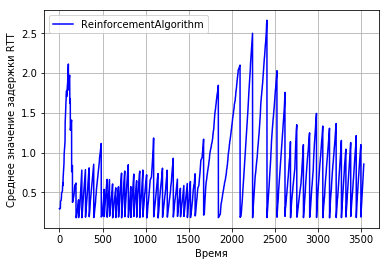

***Эпоха # 61***
[Отправитель] Подключен к получателю: 100.64.0.2:39006

***Эпоха # 62***
[Отправитель] Подключен к получателю: 100.64.0.4:42389

***Эпоха # 63***
[Отправитель] Подключен к получателю: 100.64.0.2:46693

***Эпоха # 64***
[Отправитель] Подключен к получателю: 100.64.0.4:34231

***Эпоха # 65***
[Отправитель] Подключен к получателю: 100.64.0.2:58651

***Эпоха # 66***
[Отправитель] Подключен к получателю: 100.64.0.4:46304

***Эпоха # 67***
[Отправитель] Подключен к получателю: 100.64.0.2:54680

***Эпоха # 68***
[Отправитель] Подключен к получателю: 100.64.0.2:53318

***Эпоха # 69***
[Отправитель] Подключен к получателю: 100.64.0.2:44034

***Эпоха # 70***
[Отправитель] Подключен к получателю: 100.64.0.4:52023

***Эпоха # 71***
[Отправитель] Подключен к получателю: 100.64.0.2:49905

***Эпоха # 72***
[Отправитель] Подключен к получателю: 100.64.0.4:37942

***Эпоха # 73***
[Отправитель] Подключен к получателю: 100.64.0.2:43008

***Эпоха # 74***
[Отправитель] Подключен к получате

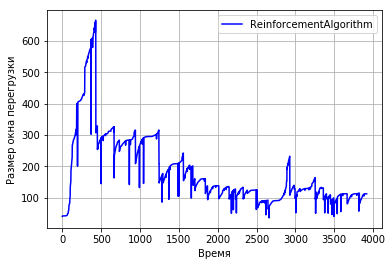

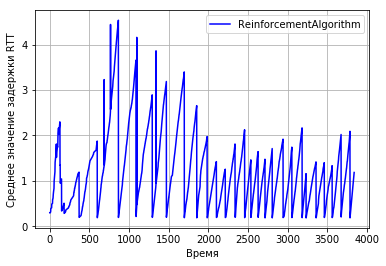

***Эпоха # 81***
[Отправитель] Подключен к получателю: 100.64.0.4:42905

***Эпоха # 82***
[Отправитель] Подключен к получателю: 100.64.0.2:45396

***Эпоха # 83***
[Отправитель] Подключен к получателю: 100.64.0.4:49958

***Эпоха # 84***
[Отправитель] Подключен к получателю: 100.64.0.2:40718

***Эпоха # 85***
[Отправитель] Подключен к получателю: 100.64.0.4:32867

***Эпоха # 86***
[Отправитель] Подключен к получателю: 100.64.0.2:42852

***Эпоха # 87***
[Отправитель] Подключен к получателю: 100.64.0.4:39738

***Эпоха # 88***
[Отправитель] Подключен к получателю: 100.64.0.2:42812

***Эпоха # 89***
[Отправитель] Подключен к получателю: 100.64.0.2:35450

***Эпоха # 90***
[Отправитель] Подключен к получателю: 100.64.0.4:51008

***Эпоха # 91***
[Отправитель] Подключен к получателю: 100.64.0.2:57248

***Эпоха # 92***
[Отправитель] Подключен к получателю: 100.64.0.2:35124

***Эпоха # 93***
[Отправитель] Подключен к получателю: 100.64.0.4:60863

***Эпоха # 94***
[Отправитель] Подключен к получате

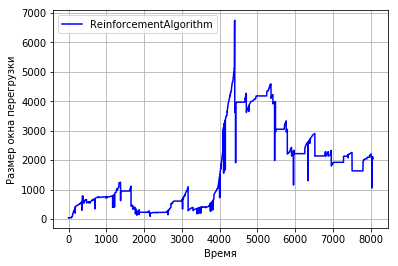

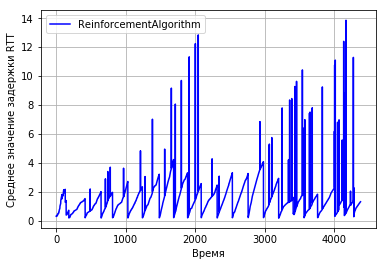

***Эпоха # 101***
[Отправитель] Подключен к получателю: 100.64.0.4:53668

***Эпоха # 102***
[Отправитель] Подключен к получателю: 100.64.0.2:56942



In [ ]:

def run_tcp_ml(hyperparameters_file_name):
    """Запуск процесса парсинга файлов и модели ML."""
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    hyperparameters = None
    with open(hyperparameters_file_name) as hyperparams_file:
        hyperparameters = json.loads(hyperparams_file.read())

    NUM_EPISODES = hyperparameters['HYPERPARAMETERS']['NUM_EPISODES']
    TARGET_UPDATE = hyperparameters['HYPERPARAMETERS']['TARGET_UPDATE']

    policy_net = LSTM_DQN(hyperparameters['lstm_config'], device).to(device=device)
    target_net = LSTM_DQN(hyperparameters['lstm_config'], device).to(device=device)

    target_net.load_state_dict(policy_net.state_dict())
    optimizer = optim.RMSprop(policy_net.parameters(), lr=0.001)
    transitions = []
    total_losses = []
    for i in range(NUM_EPISODES):
        port = open_tcp_port()
        algorithm = ReinforcementAlgorithm(policy_net = policy_net, target_net = target_net, device = device, optimizer = optimizer, hyperparameters = hyperparameters['HYPERPARAMETERS'], episode_num = i, transitions = transitions)
        print("***Эпоха # %d***" % i)
        run_mah_settings_ML(mah_settings, 60, [Sender(port, algorithm)], i%20==0, True)
        # производим запоминание rtt, cwnd, stats и очереди
        total_losses.append(algorithm.losses)
        if i % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())

run_tcp_ml(hyperparameters_file_name = 'hyperparameters_1.json')